# NLP 

**In this project, I am applying NLP techniques to analyze the text of messages. The 'label' column classifies each message as either spam or ham. The 'message' column contains the text content of each message. The 'length' column indicates the total number of words in each message, and the 'punct' column quantifies the punctuation marks used.**

**My goal is to develop a model that can accurately identify spam messages based on these features. By examining the word count and punctuation patterns, I aim to train the model to recognize the typical characteristics that differentiate spam from ham messages. This approach is crucial for improving email or messaging filtering systems by effectively filtering out unwanted spam messages.**

**The project involves preprocessing the text data, extracting key features (like word count and punctuation), and training a machine learning model on these features to classify the messages. I plan to evaluate the effectiveness of my model using various metrics to ensure it achieves high accuracy and minimizes false positives in spam detection.**

<div style="text-align: center;">
    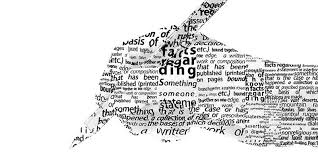
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/nathan/Desktop/UPDATED_NLP_COURSE/TextFiles/smsspamcollection.tsv', sep = '\t')
data.head(3)

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6


### Data Analysis

In [2]:
print(f'The shape of the dataset: {data.shape}.\nThe unique values as labels are: {data.label.unique()}\nThe datatypes of the dataset:\n{data.dtypes}\n')
print(f'Any missing data?\n{data.isna().sum()}\n')
print(f'Equality between Ham/Spam?\n{data.label.value_counts()}')

The shape of the dataset: (5572, 4).
The unique values as labels are: ['ham' 'spam']
The datatypes of the dataset:
label      object
message    object
length      int64
punct       int64
dtype: object

Any missing data?
label      0
message    0
length     0
punct      0
dtype: int64

Equality between Ham/Spam?
ham     4825
spam     747
Name: label, dtype: int64


In [3]:
# caracteritic of ham/spam
ham = data[data.label == 'ham']
spam = data[data.label == 'spam']


#punctuation
mean_ham_punct = round(ham.punct.mean(),2)
mean_spam_punct = round(spam.punct.mean(),2)

print(f'The Mean of Punctuation for:\nHam messages: {mean_ham_punct}\nSpan messages: {mean_spam_punct}')
print(f'We can see that "Spam" messages are meanly {mean_spam_punct - mean_ham_punct} more punctuations than Ham messages\n')

ham_length = round(ham.length.median(),2)
spam_length = round(spam.length.median(),2)

print(f'The ham messages are meanly shorter than spam messages.\nham: {ham_length}\nspam: {spam_length}')

The Mean of Punctuation for:
Ham messages: 3.94
Span messages: 5.71
We can see that "Spam" messages are meanly 1.77 more punctuations than Ham messages

The ham messages are meanly shorter than spam messages.
ham: 52.0
spam: 149.0


## Encode Categorical Features

Here we can use `OneHotEncoder` but the better method is the `LabelEncoder`, because is not a mutliclass category and only 'ham' & 'spam'

In [4]:
from sklearn.preprocessing import LabelEncoder

X = data.drop('label', axis=1)
Y = data['label']

encode = LabelEncoder()
y_encoded = encode.fit_transform(Y)
y_encoded

array([0, 0, 1, ..., 0, 0, 0])

## Encode Text: `TF-IDF` (Term Frequency-Inverse Document Frequency)

TF-IDF is a more advanced technique that not only counts the frequency of words but also takes into account the importance of the word in the entire corpus of documents.

TF (Term Frequency): Frequency of a word in a document.
IDF (Inverse Document Frequency): Decreases the importance of words that appear frequently throughout the corpus, and increases that of rare words.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #utiliser les trois pour ameliorations 
from scipy.sparse import hstack

# Transformation avec TfidfVectorizer
vectorizer = TfidfVectorizer()
x_transformed = vectorizer.fit_transform(X.message)

# Combiner les colonnes deja numériques
X_numerical = X[['length', 'punct']].values  
X_transformed = hstack([x_transformed, X_numerical])
X_transformed

<5572x8715 sparse matrix of type '<class 'numpy.float64'>'
	with 84841 stored elements in COOrdinate format>

## Train Model

**The main hyperparameters of the `LogisticRegression` model:**

**`penalty`:**

 * **l1:** When you have a large number of characteristics and you suspect that some of them are not important. l1 helps create a simpler (sparse) model by setting certain coefficients to zero.
 * **l2:** This is a good default choice. Use it if you don't have specific reasons to choose something else. It helps prevent overfitting without making the model too simple.
* **elasticnet:** When you are uncertain between l1 and l2, or if you think that both types of regularization can be beneficial. It's a combination of both.
 * **none:** If you think your model does not need regularization. This might be the case if your dataset is very large or if you have already pre-selected your features.

**`C`:**

 * **High value:** When you trust your dataset and don't want the model to be too simple. Useful if you think overfitting is not a major problem.
 * **Low value:** If you are concerned about overfitting or have a small dataset. This will make the model more regularized and therefore more generalizable.

**`solver`:**

 * **liblinear:** For small datasets or for use with l1 regularization.
 * **lbfgs, newton-cg:** For medium and large datasets. They only support l2 regularization.
 * **sag, saga:** For very large datasets. saga is the only one that supports l1, l2 and elasticnet.

**`max_iter`:**

 * **High number:** If the model does not reach convergence (i.e., has not finished learning) with the default parameters. Useful for complex datasets or with strict regularization parameters.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


np.random.seed(0)
model = LogisticRegression(penalty= 'l2', solver= 'liblinear')
x_train, x_test, y_train, y_test = train_test_split(X_transformed, y_encoded, test_size=0.2, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

## Evaluate Model

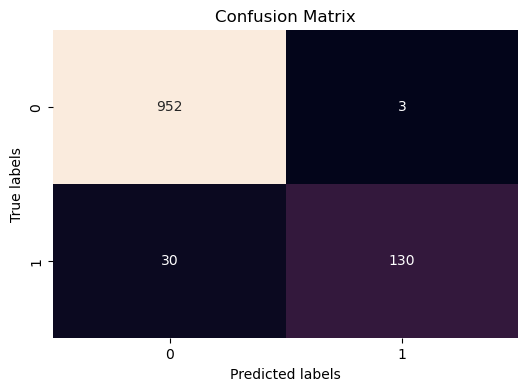

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       955
           1       0.98      0.81      0.89       160

    accuracy                           0.97      1115
   macro avg       0.97      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [7]:
from sklearn import metrics

predict = model.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test, predict)


plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(metrics.classification_report(y_true = y_test, y_pred = predict))

## Make a prediction

In [11]:
from scipy.sparse import hstack, csr_matrix
import string   # to find punctuation 

def prediction(text):
    # Transformation du texte en numerique pour que le modèle puisse comprendre
    transformed_text = vectorizer.transform(text)   

    length = [len(text[0])]    # calcule le nombre de mots. 
    punct = [sum(char in string.punctuation for char in text[0])]    # calcule le nombre de ponctuation

    # Transformation de la taille en matrix
    length_matrix = csr_matrix(length)
    punct_matrix = csr_matrix(punct)

    # Combine all the features
    combined_features = hstack([transformed_text, length_matrix, punct_matrix])  # parfois Transpose(T)
    prediction = model.predict(combined_features)

    result = ['Ham' if prediction == 0 else 'Spam']
    return result

## Enter a random text
text = ['You\'re the LUCKY winner of our lottery!!! To CLAIM your $500,000 prize, simply provide your bank details and personal information NOW!!! Act QUICKLY!!!']
prediction(text)

['Spam']